In [13]:
from rcv_distribution import *

In [17]:
# Get the consistency points for the election
points = get_consistency_points("../rcv_elections_database/classic/Maine_11062018_CongressionalDistrict2.csv")

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_learning/rcv_dimensionality.py:163: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


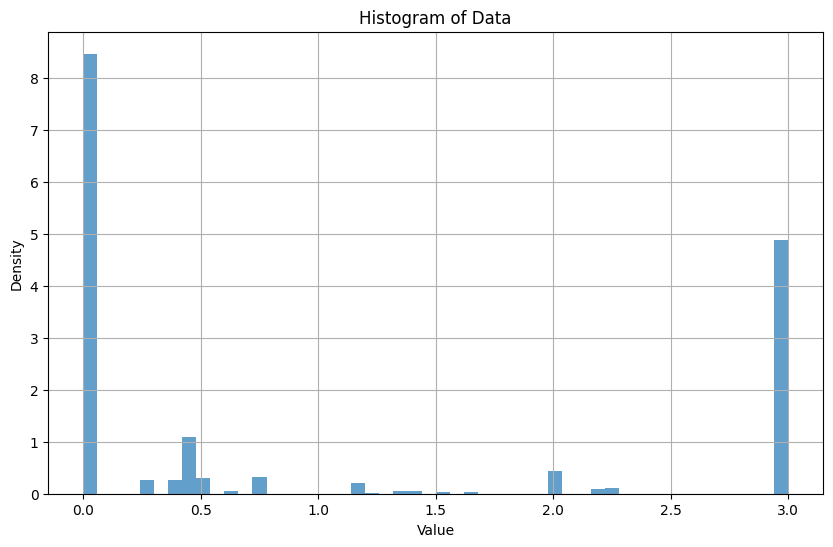

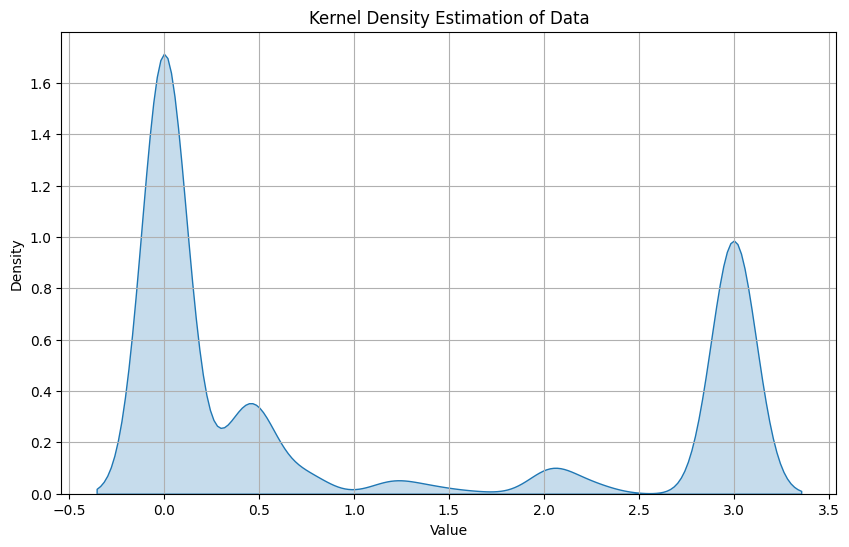

In [21]:
import seaborn as sns

# Prepare data for histogram
data_list = [x for x, count in points.items() for _ in range(count)]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data_list, bins=50, density=True, alpha=0.7)
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot kernal density estimation
plt.figure(figsize=(10, 6))
sns.kdeplot(data_list, fill=True)
plt.title('Kernel Density Estimation of Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()